# McCall Search Model - Exercise

The exercise in this notebook builds on top this lecture: https://python.quantecon.org/mccall_model.html. It is recommended to go through the lecture to get the context of this exercise easily.

#### Written for the QuantEcon Indian Summer Workshop (August 2022)
#### Author: [Smit Lunagariya](https://github.com/Smit-create)

In [1]:
!pip install quantecon

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, float64, prange
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial

### Exercise 1

We have pre-written some code from the lecture to provide basic classes and methods that we will be using in the following exercises.

In [3]:
# Pre-written code

mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

@jitclass(mccall_data)
class McCallModel:
    """
    McCall Model Class

    Parameters
    ==========

    c: float
        Unemployment compensation
    β: float
        Discount factor
    w: float array/list
        Array of wage values
    q: float array/list
        Array of probabilities
    """

    def __init__(self, c, β, w, q):

        self.c, self.β = c, β
        self.w, self.q = w, q

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])


@jit(nopython=True)
def compute_reservation_wage(mcm, max_iter=500, tol=1e-5):
    """
    Function to compute the reservation wage

    Parameters
    ==========

    mcm: McCall Model Instance
        Instance used for computing reservation wage
    max_iter: int
        Maximum number of iterations in the algorithm
    tol: float
        Tolerance limit
    """
    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute h == #

    h = np.sum(w * q) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

In [4]:
# Default parameters

n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)    # wage values

cdf = np.cumsum(q_default)                    # CDF of q

**Question 1.1**: Using the above code, write a function that takes `reservation_wage_value` as the parameter and returns how long it takes for an unemployed worker to accept a job.

In [5]:
def compute_unemployed_time(reservation_wage_value, seed):
    np.random.seed(seed)
    # write your code here
    pass

In [6]:
# Solution 1.1

def compute_unemployed_time_solution(reservation_wage_value, seed):
    # write your code here
    t = 1
    np.random.seed(seed)
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= reservation_wage_value:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

**Question 1.2**: Use numba and use the same function `compute_unemployed_time` to make it faster.

In [7]:
def compute_unemployed_time_faster(reservation_wage_value, seed=1234):
    np.random.seed(seed)
    # write your code here
    pass


In [8]:
# Solution 1.2

# Numba's Just in time compilation makes this run fast
@jit(nopython=True)
def compute_unemployed_time_faster_solution(reservation_wage_value, seed=1234):
    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= reservation_wage_value:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

### Exercise 2

**Question 2.1**: Using the above function `compute_unemployed_time_faster`, write a new function that takes `reservation_wage_value` as the parameter and returns the average duration of unemployment.

*HINT: Use the law of large numbers*

In [9]:
@jit(nopython=True)
def compute_average_unemployed_time(reservation_wage_value, num_iters=100000):
    # write your code here
    pass

In [10]:
# Solution 2.1

@jit(nopython=True)
def compute_average_unemployed_time_solution(reservation_wage_value, num_iters=100000):
    obs = np.empty(num_iters)
    for i in range(num_iters):
        obs[i] = compute_unemployed_time_faster_solution(reservation_wage_value, i)
    return obs.mean()

**Question 2.2**: Use the above `compute_average_unemployed_time` function to create a plot that shows the relation between the mean time and unemployment compensation.

In [11]:
c_vals = np.linspace(10, 40, 25)

In [12]:
# write your code here

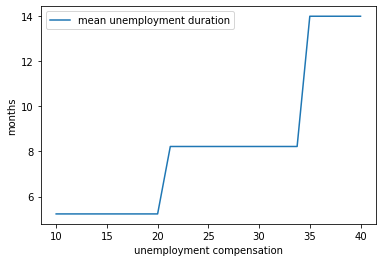

In [13]:
# Solution 2.2

stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c, β=0.99, w=w_default, q=q_default)
    w_bar = compute_reservation_wage(mcm)
    stop_times[i] = compute_average_unemployed_time_solution(w_bar)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

### Exercise 3

**Question 3.1**: Use the above `compute_average_unemployed_time` function to create a plot that uses parallelization in the loops to make the code faster to shows the relation between the mean time and unemployment compensation and different values of β in the same graph.

*HINT: See numba's `prange`*

In [14]:
β_values = [0.5, 0.75, 0.9, 0.99] 

In [15]:
# write your code here

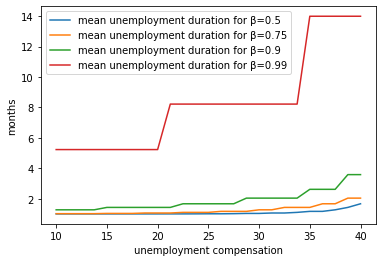

In [16]:
# Solution 3.1

fig, ax = plt.subplots()

for b in prange(len(β_values)):
    stop_times = np.empty_like(c_vals)
    for i in prange(c_vals.shape[0]):
        mcm = McCallModel(c=c_vals[i], β=β_values[b], w=w_default, q=q_default)
        w_bar = compute_reservation_wage(mcm)
        stop_times[i] = compute_average_unemployed_time_solution(w_bar)
    ax.plot(c_vals, stop_times, label="mean unemployment duration for β=" + str(β_values[b]))
    ax.set(xlabel="unemployment compensation", ylabel="months")
    ax.legend()

plt.show()